# Phase 4 : Modélisation 
**Objectif :** Construire des modèles prédictifs pour identifier les clients susceptibles de souscrire à un dépôt à terme.

---


1. **Préparation Finale des Données**
   - Chargement du dataset nettoyé (Notebook 2)
   - Exclusion de "duration" (data leakage)
   - Encodage de la variable cible (y : 0/1)
   - Séparation features (X) et target (y)
   - Identification variables catégorielles et numériques
   - Split train/test (80/20, stratifié)
   - Création du preprocessor (OneHotEncoder + StandardScaler)

2. **Modèle Baseline (KNN sans SMOTE)**
   - Configuration : KNN k=5, sans rééquilibrage
   - Objectif : Mesurer l'impact du déséquilibre
   - Métriques : Accuracy, Precision, Recall, F1-Score
   - Analyse du biais (prédictions vers "no")
   - Matrice de confusion
   - Résultat attendu : Recall faible, nécessité de SMOTE

3. **Optimisation avec SMOTE et GridSearchCV**
   - Application de SMOTE (rééquilibrage 50-50 sur train uniquement)
   - GridSearchCV sur hyperparamètres KNN :
     - n_neighbors : 3 à 19
     - weights : uniform vs distance
     - metric : euclidean vs manhattan
   - Validation croisée 5-fold
   - Métrique d'optimisation : F1-Score
   - Extraction du meilleur modèle

4. **Évaluation du Modèle KNN Optimisé**
   - Prédictions sur test set
   - Métriques complètes (Accuracy, Precision, Recall, F1)
   - Comparaison Baseline vs Optimisé
   - Matrices de confusion comparées
   - Courbes ROC et AUC
   - Analyse de l'amélioration

5. **Random Forest **
   - Pipeline : Preprocessing + SMOTE + Random Forest
   - GridSearchCV sur hyperparamètres :
     - n_estimators : 100, 200, 300
     - max_depth : 10, 20, 30, None
     - min_samples_split : 2, 5, 10
     - class_weight : balanced, None
   - Évaluation sur test set
   - Comparaison KNN vs RF
   - Feature Importance (top 15 variables)

6. **XGBoost**
   - Pipeline : Preprocessing + SMOTE + XGBoost
   - GridSearchCV sur hyperparamètres :
     - n_estimators : 100, 200, 300
     - max_depth : 3, 5, 7
     - learning_rate : 0.01, 0.1, 0.3
     - scale_pos_weight : 1, ratio_no_yes
   - Évaluation sur test set
   - Comparaison KNN vs RF vs XGBoost
   - Feature Importance

7. **Comparaison Finale et Sélection du Meilleur Modèle**
   - Tableau comparatif des 3 modèles
   - Analyse par métrique (F1, Recall, Precision, AUC)
   - Sélection du modèle optimal (score combiné)
   - Interprétation métier et impact business
   - Visualisations comparatives (barplots + courbes ROC)
   - Recommandations finales

---



## Imports et configs

In [5]:
# Imports des bibliotheques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, classification_report
)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings



In [6]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Style des graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Seed pour reproductibilite
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## PARTIE 1 : Préparation Finale des Données

**Objectif :** Préparer le dataset pour la modélisation KNN.

**Actions à réaliser :**

1. **Charger le dataset nettoyé** (Notebook 2)
2. **Exclure "duration"** (data leakage)
3. **Séparer features (X) et target (y)**
4. **Identifier variables catégorielles et numériques**
5. **Split train/test** (80/20, stratifié sur y)
6. **Créer le preprocessor** (OneHotEncoder + StandardScaler)



In [7]:

file_path = r'A:\Mes documents\projet analyse exploiratoire\data\bank-additional-full-cleaned.csv'
df = pd.read_csv(file_path, sep=';')

print(f"\nDataset charge : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")


Dataset charge : 40,858 lignes × 21 colonnes


In [8]:
# Verification variable cible
y_dist = df['y'].value_counts()
print(f"\nDistribution de y :")
print(f"  no  : {y_dist['no']:,} ({y_dist['no']/len(df)*100:.2f}%)")
print(f"  yes : {y_dist['yes']:,} ({y_dist['yes']/len(df)*100:.2f}%)")


Distribution de y :
  no  : 36,255 (88.73%)
  yes : 4,603 (11.27%)


In [9]:
#exclusion variable 'duration' (data leakage)
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])
    print("Variable 'duration' exclue (data leakage)")
    print(f"Dataset apres exclusion : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
else:
    print("Variable 'duration' deja absente")

Variable 'duration' exclue (data leakage)
Dataset apres exclusion : 40,858 lignes × 20 colonnes


In [10]:
# 3. Features / cible
X = df.drop(columns=['y'])
y = df['y']

print(f"\nX (features) : {X.shape[0]:,} lignes × {X.shape[1]} colonnes")
print(f"y (target)   : {len(y):,} valeurs")



X (features) : 40,858 lignes × 19 colonnes
y (target)   : 40,858 valeurs


In [11]:
#  Encodage de la variable cible

print(f"\nAvant encodage : type = {type(y.iloc[0])}, valeurs = {y.unique()}")

# Encodage: 'no' -> 0, 'yes' -> 1
y = y.map({'no': 0, 'yes': 1})

print(f"Apres encodage : type = {type(y.iloc[0])}, valeurs = {y.unique()}")
print(f"\nEncodage applique :")
print(f"  'no'  -> 0")
print(f"  'yes' -> 1")

# Vérification
print(f"\nDistribution apres encodage :")
y_encoded_dist = y.value_counts()
print(f"  0 (no)  : {y_encoded_dist[0]:,} ({y_encoded_dist[0]/len(y)*100:.2f}%)")
print(f"  1 (yes) : {y_encoded_dist[1]:,} ({y_encoded_dist[1]/len(y)*100:.2f}%)")


Avant encodage : type = <class 'str'>, valeurs = ['no' 'yes']
Apres encodage : type = <class 'numpy.int64'>, valeurs = [0 1]

Encodage applique :
  'no'  -> 0
  'yes' -> 1

Distribution apres encodage :
  0 (no)  : 36,255 (88.73%)
  1 (yes) : 4,603 (11.27%)


In [12]:

# Variables categorielles
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\n{len(categorical_cols)} variables categorielles :")
print(categorical_cols)

# Variables numeriques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\n{len(numerical_cols)} variables numeriques :")
print(numerical_cols)


10 variables categorielles :
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

9 variables numeriques :
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [13]:
#  Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\nTrain set : {X_train.shape[0]:,} lignes ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set  : {X_test.shape[0]:,} lignes ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verification stratification
print(f"\nDistribution y dans train :")
train_dist = y_train.value_counts(normalize=True) * 100
print(f"  0 (no)  : {train_dist[0]:.2f}%")
print(f"  1 (yes) : {train_dist[1]:.2f}%")

print(f"\nDistribution y dans test :")
test_dist = y_test.value_counts(normalize=True) * 100
print(f"  0 (no)  : {test_dist[0]:.2f}%")
print(f"  1 (yes) : {test_dist[1]:.2f}%")




Train set : 32,686 lignes (80.0%)
Test set  : 8,172 lignes (20.0%)

Distribution y dans train :
  0 (no)  : 88.74%
  1 (yes) : 11.26%

Distribution y dans test :
  0 (no)  : 88.73%
  1 (yes) : 11.27%


In [14]:
#creation du processor 


# ColumnTransformer pour appliquer transformations differentes
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

print("\n")
print(f"\nDataset pret pour modelisation :")
print(f"  Train : {X_train.shape[0]:,} lignes")
print(f"  Test  : {X_test.shape[0]:,} lignes")
print(f"  Features : {X.shape[1]}")
print(f"  Desequilibre : {y_train.value_counts(normalize=True)[1]*100:.2f}% yes")




Dataset pret pour modelisation :
  Train : 32,686 lignes
  Test  : 8,172 lignes
  Features : 19
  Desequilibre : 11.26% yes


## PARTIE 2 : Modèle Baseline (Sans Rééquilibrage)

**Objectif :** Établir une baseline de référence avant d'appliquer SMOTE.

**Pourquoi une baseline ?**
- Mesurer l'impact du déséquilibre sur les performances
- Avoir un point de comparaison pour évaluer l'amélioration apportée par SMOTE
- Identifier le biais du modèle (prédit-il toujours "no" ?)

**Configuration baseline :**
- Modèle : KNN avec k=5 (valeur standard)
- Aucun rééquilibrage (classes déséquilibrées : 11.26% yes)
- Pipeline : Preprocessing + KNN

**Métriques à observer :**
- **Accuracy** : Peut être trompeuse avec déséquilibre 
- **Recall (yes)** : Proportion de vrais "yes" correctement identifiés (métrique clé)
- **Precision (yes)** : Proportion de prédictions "yes" qui sont correctes
- **F1-Score** : Équilibre entre Precision et Recall (métrique principale)

**Résultat attendu :**
- Le modèle sera probablement biaisé vers "no" (classe majoritaire)
- Recall faible pour "yes" (beaucoup de faux négatifs)
- Nécessité de SMOTE pour corriger ce biais



In [15]:
#  MODELE BASELINE : KNN SANS REEQUILIBRAGE


print("\nConfiguration :")
print("  - Modele : KNN (k=5)")
print("  - Reequilibrage : Aucun")
print("  - Train : 32,686 lignes (11.26% yes)")
print("  - Test  : 8,172 lignes (11.27% yes)")

# Creation du pipeline baseline
pipe_baseline = Pipeline([ 
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
print("\nEntrainement du modele baseline...")
pipe_baseline.fit(X_train, y_train)

# Predictions
y_pred_baseline = pipe_baseline.predict(X_test)
y_prob_baseline = pipe_baseline.predict_proba(X_test)[:, 1]

print("Entrainement fini")


Configuration :
  - Modele : KNN (k=5)
  - Reequilibrage : Aucun
  - Train : 32,686 lignes (11.26% yes)
  - Test  : 8,172 lignes (11.27% yes)

Entrainement du modele baseline...
Entrainement fini



Accuracy  : 0.8906
Precision : 0.5277 (parmi les predictions 'yes', combien sont vraies)
Recall    : 0.2790 (parmi les vrais 'yes', combien sont detectes)
F1-Score  : 0.3651 (equilibre Precision/Recall)


CLASSIFICATION REPORT DETAILLE
              precision    recall  f1-score   support

      no (0)       0.91      0.97      0.94      7251
     yes (1)       0.53      0.28      0.37       921

    accuracy                           0.89      8172
   macro avg       0.72      0.62      0.65      8172
weighted avg       0.87      0.89      0.88      8172



[[7021  230]
 [ 664  257]]

True Negatives  (TN) : 7,021 (vrais 'no' correctement predits)
False Positives (FP) : 230 (predits 'yes' mais vrais 'no')
False Negatives (FN) : 664 (predits 'no' mais vrais 'yes') <- PROBLEME
True Positives  (TP) : 257 (vrais 'yes' correctement predits)


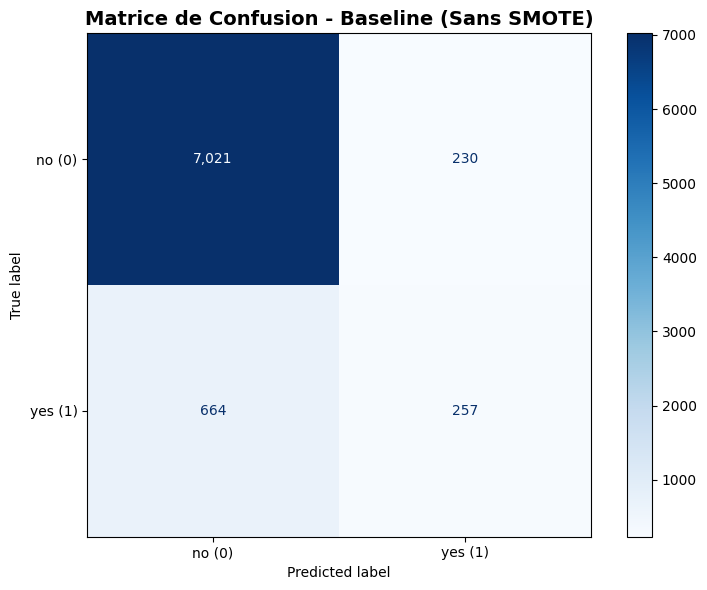


Graphique sauvegarde : 09_confusion_matrix_baseline.png


In [16]:
# EVALUATION DU MODELE BASELINE


acc_baseline = accuracy_score(y_test, y_pred_baseline)
prec_baseline = precision_score(y_test, y_pred_baseline, pos_label=1)
rec_baseline = recall_score(y_test, y_pred_baseline, pos_label=1)
f1_baseline = f1_score(y_test, y_pred_baseline, pos_label=1)

print(f"\nAccuracy  : {acc_baseline:.4f}")
print(f"Precision : {prec_baseline:.4f} (parmi les predictions 'yes', combien sont vraies)")
print(f"Recall    : {rec_baseline:.4f} (parmi les vrais 'yes', combien sont detectes)")
print(f"F1-Score  : {f1_baseline:.4f} (equilibre Precision/Recall)")


# Classification Report detaille
print("\n" )
print("CLASSIFICATION REPORT DETAILLE")
print(classification_report(y_test, y_pred_baseline, target_names=['no (0)', 'yes (1)']))


# Matrice de confusion
cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=[0, 1])
print("\n")
print(cm_baseline)



# Calcul des composantes
tn, fp, fn, tp = cm_baseline.ravel()
print(f"\nTrue Negatives  (TN) : {tn:,} (vrais 'no' correctement predits)")
print(f"False Positives (FP) : {fp:,} (predits 'yes' mais vrais 'no')")
print(f"False Negatives (FN) : {fn:,} (predits 'no' mais vrais 'yes') <- PROBLEME")
print(f"True Positives  (TP) : {tp:,} (vrais 'yes' correctement predits)")



# Visualisation matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['no (0)', 'yes (1)'])
disp.plot(cmap='Blues', ax=ax, values_format=',')
ax.set_title('Matrice de Confusion - Baseline (Sans SMOTE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\09_confusion_matrix_baseline.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegarde : 09_confusion_matrix_baseline.png")

In [17]:
#analyse du biais



# Distribution des predictions
pred_dist = pd.Series(y_pred_baseline).value_counts()
print(f"\nDistribution des predictions :")
print(f"  0 (no)  predit : {pred_dist.get(0, 0):,} fois ({pred_dist.get(0, 0)/len(y_pred_baseline)*100:.2f}%)")
print(f"  1 (yes) predit : {pred_dist.get(1, 0):,} fois ({pred_dist.get(1, 0)/len(y_pred_baseline)*100:.2f}%)")

print(f"\nDistribution reelle dans test :")
real_dist = y_test.value_counts()
print(f"  0 (no)  reel : {real_dist[0]:,} ({real_dist[0]/len(y_test)*100:.2f}%)")
print(f"  1 (yes) reel : {real_dist[1]:,} ({real_dist[1]/len(y_test)*100:.2f}%)")


# Calcul taux de detection yes
taux_detection_yes = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
print(f"\nTaux de detection 'yes' : {taux_detection_yes:.2f}%")
print(f"Faux negatifs (yes rates) : {fn:,} sur {tp+fn:,} vrais 'yes'")



Distribution des predictions :
  0 (no)  predit : 7,685 fois (94.04%)
  1 (yes) predit : 487 fois (5.96%)

Distribution reelle dans test :
  0 (no)  reel : 7,251 (88.73%)
  1 (yes) reel : 921 (11.27%)

Taux de detection 'yes' : 27.90%
Faux negatifs (yes rates) : 664 sur 921 vrais 'yes'


In [18]:
# Synthese baseline 
print("\nOBSERVATIONS :")

if rec_baseline < 0.5:
    print("  1. Recall tres FAIBLE pour 'yes' (< 50%)")
    print("     - Le modele rate plus de la moitie des clients 'yes'")
    print("     - Fort biais vers la classe majoritaire 'no'")
elif rec_baseline < 0.7:
    print("  1. Recall MOYEN pour 'yes' (50-70%)")
    print("     - Le modele detecte une partie des 'yes' mais en rate beaucoup")
else:
    print("  1. Recall BON pour 'yes' (> 70%)")

if f1_baseline < 0.3:
    print("  2. F1-Score FAIBLE (< 0.3)")
    print("     - Performances globales insuffisantes sur classe minoritaire")
elif f1_baseline < 0.5:
    print("  2. F1-Score MOYEN (0.3-0.5)")
    print("     - Performances moderees, amelioration possible")
else:
    print("  2. F1-Score BON (> 0.5)")

print(f"\nCONCLUSION :")
print(f"  Le desequilibre des classes (11.27% yes) impacte les performances.")
print(f"  Le modele est biaise vers 'no' (classe majoritaire).")
print(f"   SMOTE est NECESSAIRE pour reequilibrer et ameliorer le Recall.")



OBSERVATIONS :
  1. Recall tres FAIBLE pour 'yes' (< 50%)
     - Le modele rate plus de la moitie des clients 'yes'
     - Fort biais vers la classe majoritaire 'no'
  2. F1-Score MOYEN (0.3-0.5)
     - Performances moderees, amelioration possible

CONCLUSION :
  Le desequilibre des classes (11.27% yes) impacte les performances.
  Le modele est biaise vers 'no' (classe majoritaire).
   SMOTE est NECESSAIRE pour reequilibrer et ameliorer le Recall.


## PARTIE 3 : Optimisation avec SMOTE et GridSearchCV

**Objectif :** Améliorer les performances en rééquilibrant les classes et en optimisant les hyperparamètres.

**Problème identifié (Baseline) :**
- Recall "yes" catastrophique : 27.90%
- 664 clients "yes" ratés sur 921 (72% de faux négatifs)
- Biais fort vers "no" (94% des prédictions)

**Solution : SMOTE (Synthetic Minority Over-sampling Technique)**

**Qu'est-ce que SMOTE ?**
- Technique de rééquilibrage par sur-échantillonnage de la classe minoritaire
- Crée des exemples synthétiques de "yes" en interpolant entre exemples existants
- S'applique UNIQUEMENT sur le train set (jamais sur test)
- Objectif : Équilibrer à 50% yes / 50% no dans train

**Comment ça marche ?**
1. Pour chaque exemple "yes", SMOTE trouve ses k plus proches voisins "yes"
2. Crée de nouveaux points synthétiques entre l'exemple et ses voisins
3. Répète jusqu'à atteindre l'équilibre souhaité

**Optimisation des hyperparamètres (GridSearchCV) :**

Paramètres à tester :
- **n_neighbors** (k) : 3, 5, 7, 9, 11, 13, 15, 17, 19
- **weights** : 'uniform' (tous voisins égaux) vs 'distance' (pondération par distance)
- **metric** : 'euclidean' (distance classique) vs 'manhattan' (distance Manhattan)

**Métrique d'optimisation : F1-Score**
- Équilibre entre Precision et Recall
- Adaptée aux problèmes déséquilibrés
- Pénalise les modèles biaisés

**Validation croisée : 5-fold**
- Divise train en 5 parties
- Entraîne sur 4, teste sur 1
- Répète 5 fois
- Score final = moyenne des 5 scores

**Résultat attendu :**
- Amélioration significative du Recall (objectif > 60%)
- Réduction des faux négatifs
- F1-Score > 0.50



In [19]:
#optimisation avec SMOTE

print("\nConfiguration SMOTE :")
print("  - Strategie : Reequilibrage 50-50 sur train uniquement")
print("  - Methode : Creation exemples synthetiques de 'yes'")
print(f"  - Train avant SMOTE : {y_train.value_counts()[1]:,} yes ({y_train.value_counts(normalize=True)[1]*100:.2f}%)")
print(f"  - Train apres SMOTE : {y_train.value_counts()[0]:,} yes (50%)")



Configuration SMOTE :
  - Strategie : Reequilibrage 50-50 sur train uniquement
  - Methode : Creation exemples synthetiques de 'yes'
  - Train avant SMOTE : 3,682 yes (11.26%)
  - Train apres SMOTE : 29,004 yes (50%)


In [20]:
# DEFINITION DU PIPELINE AVEC SMOTE

# Pipeline avec SMOTE (ImbPipeline)
pipe_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier())
])



In [21]:
# DEFINITION DE LA GRILLE DE PARAMETRES

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

print(f"\nParametres a tester :")
print(f"  - n_neighbors (k) : {param_grid['knn__n_neighbors']}")
print(f"  - weights : {param_grid['knn__weights']}")
print(f"  - metric : {param_grid['knn__metric']}")

nb_combinaisons = (len(param_grid['knn__n_neighbors']) * 
                   len(param_grid['knn__weights']) * 
                   len(param_grid['knn__metric']))
print(f"\nNombre total de combinaisons : {nb_combinaisons}")
print(f"Avec validation croisee 5-fold : {nb_combinaisons * 5} entrainements")



Parametres a tester :
  - n_neighbors (k) : [3, 5, 7, 9, 11, 13, 15, 17, 19]
  - weights : ['uniform', 'distance']
  - metric : ['euclidean', 'manhattan']

Nombre total de combinaisons : 36
Avec validation croisee 5-fold : 180 entrainements


In [22]:
# GRIDSEARCHCV

grid = GridSearchCV(
    estimator=pipe_smote,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nGridSearchCV termine")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

GridSearchCV termine


In [23]:
# RESULTATS GRIDSEARCH 


best_params = grid.best_params_
best_score = grid.best_score_

print(f"\nMeilleurs hyperparametres trouves :")
print(f"  - k (n_neighbors) : {best_params['knn__n_neighbors']}")
print(f"  - weights : {best_params['knn__weights']}")
print(f"  - metric : {best_params['knn__metric']}")

print(f"\nMeilleur F1-Score (validation croisee) : {best_score:.4f}")



print("\n")
print("TOP 5 DES COMBINAISONS")
results_df = pd.DataFrame(grid.cv_results_)
top5 = results_df.nlargest(5, 'mean_test_score')[['param_knn__n_neighbors', 
                                                     'param_knn__weights', 
                                                     'param_knn__metric', 
                                                     'mean_test_score']]
top5.columns = ['k', 'weights', 'metric', 'F1-Score']
print("\n")
print(top5.to_string(index=False))


Meilleurs hyperparametres trouves :
  - k (n_neighbors) : 19
  - weights : distance
  - metric : manhattan

Meilleur F1-Score (validation croisee) : 0.4049


TOP 5 DES COMBINAISONS


 k  weights    metric  F1-Score
19 distance manhattan    0.4049
17 distance manhattan    0.4028
15 distance manhattan    0.4021
13 distance manhattan    0.3978
19  uniform manhattan    0.3976


In [24]:
# EXTRACTION DU MEILLEUR MODELE

best_model = grid.best_estimator_

print(f"\nModele optimal extrait avec :")
print(f"  k={best_params['knn__n_neighbors']}, weights='{best_params['knn__weights']}', metric='{best_params['knn__metric']}'")


print(f"\nAmelioration attendue par rapport a baseline :")
print(f"  Baseline F1-Score : {f1_baseline:.4f}")
print(f"  Optimal F1-Score  : {best_score:.4f}")
print(f"  Gain absolu : +{best_score - f1_baseline:.4f}")
print(f"  Gain relatif : +{(best_score - f1_baseline)/f1_baseline*100:.1f}%")


Modele optimal extrait avec :
  k=19, weights='distance', metric='manhattan'

Amelioration attendue par rapport a baseline :
  Baseline F1-Score : 0.3651
  Optimal F1-Score  : 0.4049
  Gain absolu : +0.0399
  Gain relatif : +10.9%



Modele final : KNN optimise (k=19, weights='distance', metric='manhattan')


PREDICTIONS SUR TEST SET



Predictions realisees sur 8,172 clients


METRIQUES DETAILLEES



Accuracy  : 0.8173
Precision : 0.3289 (parmi predictions 'yes', combien sont vraies)
Recall    : 0.5972 (parmi vrais 'yes', combien sont detectes)
F1-Score  : 0.4242 (equilibre Precision/Recall)


CLASSIFICATION REPORT


              precision    recall  f1-score   support

      no (0)       0.94      0.85      0.89      7251
     yes (1)       0.33      0.60      0.42       921

    accuracy                           0.82      8172
   macro avg       0.64      0.72      0.66      8172
weighted avg       0.87      0.82      0.84      8172



COMPARAISON BASELINE VS MODELE FINAL




 Metrique  Baseline  Final    Gain   Gain %
 Accuracy    0.8906 0.8173 -0.0733  -8.2000
Precision    0.5277 0.3289 -0.1988 -37.7000
   Recall    0.2790 0.5972  0.3181 114.0000
 F1-Score    0.3651 0.4242  0.0592  16.2000

Plus grande amel

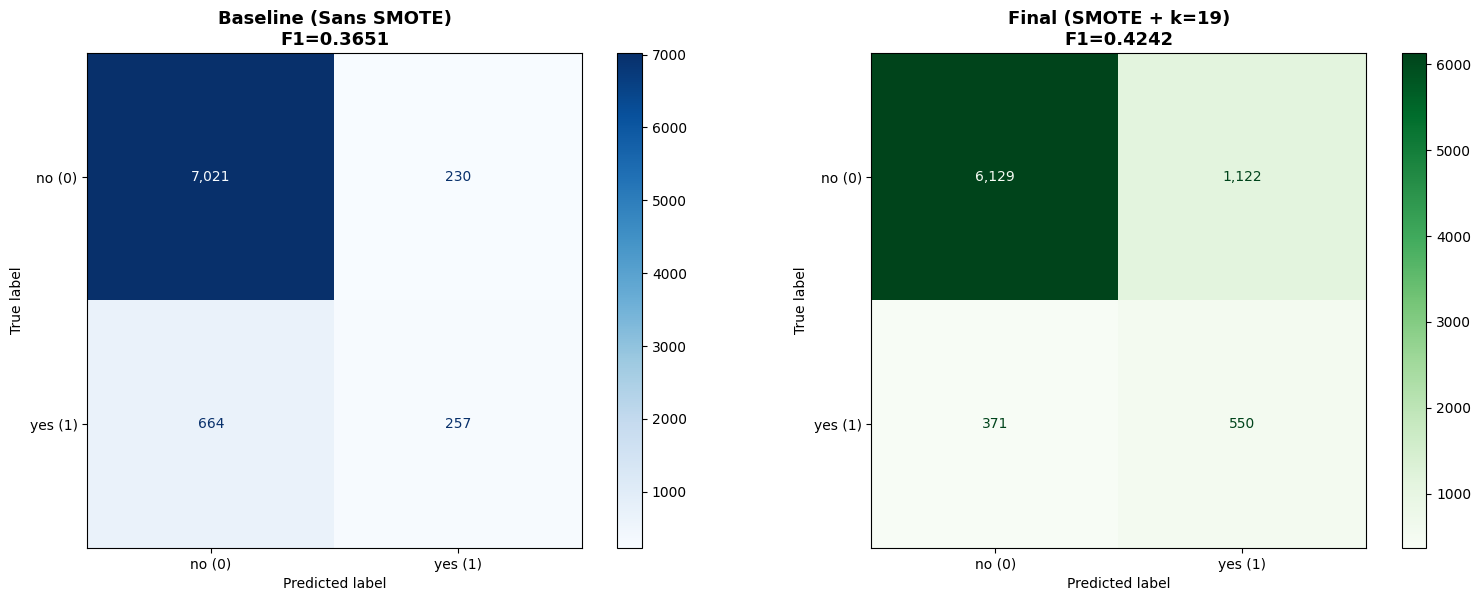


Graphique sauvegarde : 10_comparison_confusion_matrices.png


In [25]:
#evaluation du modele final sur test set

print(f"\nModele final : KNN optimise (k={best_params['knn__n_neighbors']}, weights='{best_params['knn__weights']}', metric='{best_params['knn__metric']}')")


print("\n")
print("PREDICTIONS SUR TEST SET")
print("\n")

y_pred_final = best_model.predict(X_test)
y_prob_final = best_model.predict_proba(X_test)[:, 1]

print(f"\nPredictions realisees sur {len(y_test):,} clients")



print("\n")
print("METRIQUES DETAILLEES")
print("\n")

acc_final = accuracy_score(y_test, y_pred_final)
prec_final = precision_score(y_test, y_pred_final, pos_label=1)
rec_final = recall_score(y_test, y_pred_final, pos_label=1)
f1_final = f1_score(y_test, y_pred_final, pos_label=1)

print(f"\nAccuracy  : {acc_final:.4f}")
print(f"Precision : {prec_final:.4f} (parmi predictions 'yes', combien sont vraies)")
print(f"Recall    : {rec_final:.4f} (parmi vrais 'yes', combien sont detectes)")
print(f"F1-Score  : {f1_final:.4f} (equilibre Precision/Recall)")



# Classification report
print("\n")
print("CLASSIFICATION REPORT")
print("\n")
print(classification_report(y_test, y_pred_final, target_names=['no (0)', 'yes (1)']))

#comparaison avec baseline
print("\n")
print("COMPARAISON BASELINE VS MODELE FINAL")
print("\n")

comparison = pd.DataFrame({
    'Metrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [acc_baseline, prec_baseline, rec_baseline, f1_baseline],
    'Final': [acc_final, prec_final, rec_final, f1_final]
})

comparison['Gain'] = comparison['Final'] - comparison['Baseline']
comparison['Gain %'] = (comparison['Gain'] / comparison['Baseline'] * 100).round(1)

print("\n")
print(comparison.to_string(index=False))

# identification de la metrique avec le plus grand gain en pourcentage
best_improvement_idx = comparison['Gain %'].idxmax()
best_metric = comparison.loc[best_improvement_idx, 'Metrique']
best_gain = comparison.loc[best_improvement_idx, 'Gain %']

print(f"\nPlus grande amelioration : {best_metric} (+{best_gain:.1f}%)")

# MATRICE DE CONFUSION
cm_final = confusion_matrix(y_test, y_pred_final, labels=[0, 1])
print("\n")
print(cm_final)

tn_final, fp_final, fn_final, tp_final = cm_final.ravel()

print(f"\nTrue Negatives  (TN) : {tn_final:,} (vrais 'no' correctement predits)")
print(f"False Positives (FP) : {fp_final:,} (predits 'yes' mais vrais 'no')")
print(f"False Negatives (FN) : {fn_final:,} (predits 'no' mais vrais 'yes')")
print(f"True Positives  (TP) : {tp_final:,} (vrais 'yes' correctement predits)")

# Comparaison avec baseline
print(f"\nComparaison avec baseline :")
print(f"  Baseline - FN : {fn:,} (clients 'yes' rates)")
print(f"  Final    - FN : {fn_final:,} (clients 'yes' rates)")
print(f"  Reduction FN  : {fn - fn_final:,} clients ({(fn - fn_final)/fn*100:.1f}%)")
print(f"   {fn - fn_final:,} opportunites commerciales RECUPEREES")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))





# Baseline
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['no (0)', 'yes (1)'])
disp_baseline.plot(cmap='Blues', ax=axes[0], values_format=',')
axes[0].set_title(f'Baseline (Sans SMOTE)\nF1={f1_baseline:.4f}', fontsize=13, fontweight='bold')

# model
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['no (0)', 'yes (1)'])
disp_final.plot(cmap='Greens', ax=axes[1], values_format=',')
axes[1].set_title(f'Final (SMOTE + k={best_params["knn__n_neighbors"]})\nF1={f1_final:.4f}', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\10_comparison_confusion_matrices.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegarde : 10_comparison_confusion_matrices.png")







AUC-ROC Baseline : 0.7267
AUC-ROC Final    : 0.7570
Gain AUC         : +0.0304


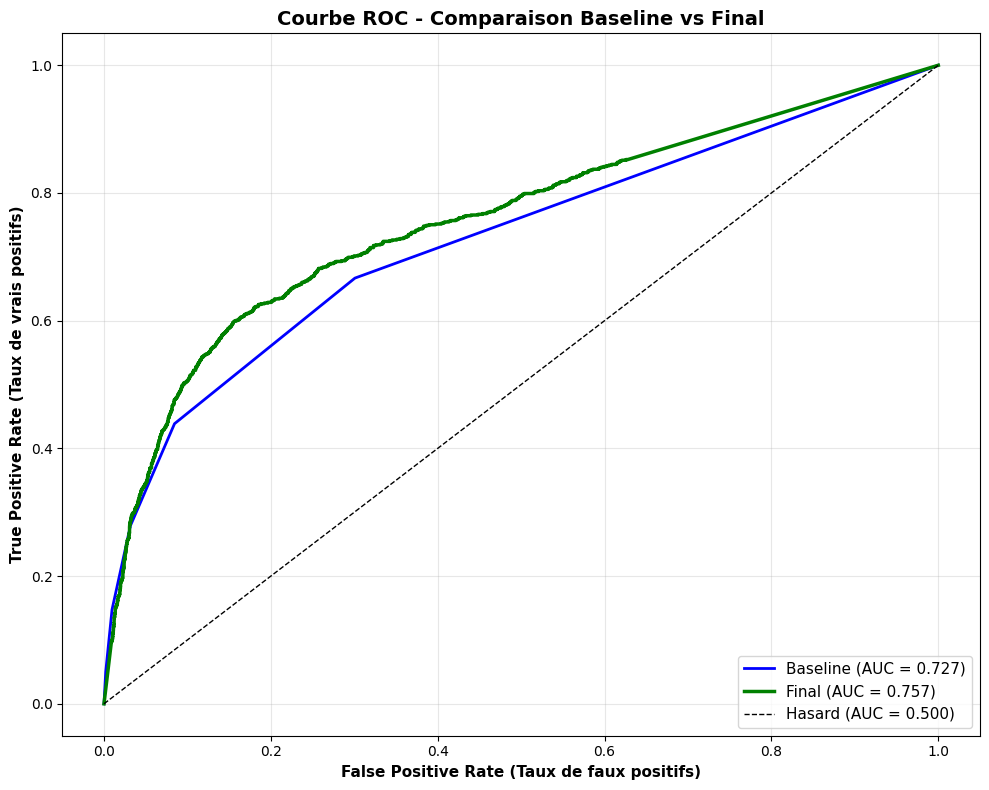


Graphique sauvegarde : 11_roc_comparison.png

Interpretation AUC-ROC :
  Bon (0.7-0.8) : Modele performant


In [26]:
# courbe ROC et AUC

# Calculer ROC pour baseline et le model 
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_prob_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

fpr_final, tpr_final, _ = roc_curve(y_test, y_prob_final)
roc_auc_final = auc(fpr_final, tpr_final)

print(f"\nAUC-ROC Baseline : {roc_auc_baseline:.4f}")
print(f"AUC-ROC Final    : {roc_auc_final:.4f}")
print(f"Gain AUC         : +{roc_auc_final - roc_auc_baseline:.4f}")

fig, ax = plt.subplots(figsize=(10, 8))

# Baseline
ax.plot(fpr_baseline, tpr_baseline, color='blue', linewidth=2, 
        label=f'Baseline (AUC = {roc_auc_baseline:.3f})')

# Final
ax.plot(fpr_final, tpr_final, color='green', linewidth=2.5, 
        label=f'Final (AUC = {roc_auc_final:.3f})')

# Diagonale (hasard)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Hasard (AUC = 0.500)')

ax.set_xlabel('False Positive Rate (Taux de faux positifs)', fontweight='bold', fontsize=11)
ax.set_ylabel('True Positive Rate (Taux de vrais positifs)', fontweight='bold', fontsize=11)
ax.set_title('Courbe ROC - Comparaison Baseline vs Final', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\11_roc_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegarde : 11_roc_comparison.png")

# Interpretation AUC
print("\nInterpretation AUC-ROC :")
if roc_auc_final > 0.8:
    print("  Excellent (> 0.8) : Modele tres discriminant")
elif roc_auc_final > 0.7:
    print("  Bon (0.7-0.8) : Modele performant")
elif roc_auc_final > 0.6:
    print("  Moyen (0.6-0.7) : Modele acceptable")
else:
    print("  Faible (< 0.6) : Modele peu discriminant")



## PARTIE 5 : Random Forest (Modèle Avancé)

**Objectif :** Améliorer les performances avec un algorithme ensemble.

**Pourquoi Random Forest après KNN ?**

**KNN obtenu :**
- F1-Score : 0.4242
- Recall : 59.72%
- AUC-ROC : 0.757

**Limitations KNN :**
- Sensible à la dimensionnalité (curse of dimensionality)
- Precision faible (32.89%) → trop de faux positifs
- Calcul coûteux en production

**Avantages Random Forest :**

1. **Meilleure gestion du déséquilibre**
   - `class_weight='balanced'` natif
   - Moins sensible au bruit

2. **Robustesse**
   - Agrégation de multiples arbres
   - Réduction overfitting

3. **Feature Importance natif**
   - Identification directe des variables clés
   - Validation des insights Notebook 3

4. **Performances attendues**
   - F1-Score : 0.48-0.52
   - Amélioration Precision
   - Maintien Recall élevé

**Hyperparamètres clés :**
- `n_estimators` : Nombre d'arbres (100, 200, 300)
- `max_depth` : Profondeur arbres (10, 20, 30, None)
- `min_samples_split` : Split minimum (2, 5, 10)
- `class_weight` : Gestion déséquilibre ('balanced', None)

In [27]:
from sklearn.ensemble import RandomForestClassifier

print(f"  - Baseline KNN : F1 = {f1_final:.4f}, Recall = {rec_final:.4f}")

  - Baseline KNN : F1 = 0.4242, Recall = 0.5972


In [28]:
# Pipeline Random Forest

pipe_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])




In [29]:
# Grille de parametres p
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__class_weight': ['balanced', None]
}

print(f"\nParametres :")
for key, values in param_grid_rf.items():
    print(f"  - {key.replace('rf__', '')} : {values}")

nb_comb_rf = 3 * 4 * 3 * 2  # 72 combinaisons
print(f"\nCombinaisons : {nb_comb_rf}")
print(f"Avec 5-fold CV : {nb_comb_rf * 5} = 360 entrainements")




Parametres :
  - n_estimators : [100, 200, 300]
  - max_depth : [10, 20, 30, None]
  - min_samples_split : [2, 5, 10]
  - class_weight : ['balanced', None]

Combinaisons : 72
Avec 5-fold CV : 360 = 360 entrainements


In [30]:
#gridsearchcv
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nEntrainement en cours...")
import time
start_time = time.time()

grid_rf.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nTermine en {elapsed_time/60:.1f} minutes")



Entrainement en cours...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Termine en 30.0 minutes


In [31]:
# Resultats

best_params_rf = grid_rf.best_params_
best_score_rf_cv = grid_rf.best_score_

print(f"\nMeilleurs hyperparametres :")
for param, value in best_params_rf.items():
    print(f"  - {param.replace('rf__', '')} : {value}")

print(f"\nMeilleur F1-Score (CV) : {best_score_rf_cv:.4f}")

# Top 5
results_rf = pd.DataFrame(grid_rf.cv_results_)
top5_rf = results_rf.nlargest(5, 'mean_test_score')[
    ['param_rf__n_estimators', 'param_rf__max_depth', 
     'param_rf__min_samples_split', 'param_rf__class_weight', 
     'mean_test_score']
]
top5_rf.columns = ['n_trees', 'max_depth', 'min_split', 'class_weight', 'F1-Score']

print("\nTop 5 :")
print(top5_rf.to_string(index=False))



Meilleurs hyperparametres :
  - class_weight : balanced
  - max_depth : 10
  - min_samples_split : 5
  - n_estimators : 200

Meilleur F1-Score (CV) : 0.4989

Top 5 :
 n_trees max_depth  min_split class_weight  F1-Score
     200        10          5     balanced    0.4989
     200        10          5         None    0.4989
     100        10          5     balanced    0.4983
     100        10          5         None    0.4983
     300        10          5     balanced    0.4980


In [32]:
# evaluation sur le test set 

best_model_rf = grid_rf.best_estimator_

y_pred_rf = best_model_rf.predict(X_test)
y_prob_rf = best_model_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, pos_label=1)
rec_rf = recall_score(y_test, y_pred_rf, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)

print(f"\nPerformances Random Forest :")
print(f"  Accuracy  : {acc_rf:.4f}")
print(f"  Precision : {prec_rf:.4f}")
print(f"  Recall    : {rec_rf:.4f}")
print(f"  F1-Score  : {f1_rf:.4f}")

# ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"  AUC-ROC   : {roc_auc_rf:.4f}")

# Comparaison KNN vs RF
print(f"\n")
print("COMPARAISON KNN vs RF")

comparison_knn_rf = pd.DataFrame({
    'Metrique': ['F1-Score', 'Recall', 'Precision', 'AUC-ROC'],
    'KNN': [f1_final, rec_final, prec_final, roc_auc_final],
    'RF': [f1_rf, rec_rf, prec_rf, roc_auc_rf]
})
comparison_knn_rf['Gain'] = comparison_knn_rf['RF'] - comparison_knn_rf['KNN']
comparison_knn_rf['Gain %'] = (comparison_knn_rf['Gain'] / comparison_knn_rf['KNN'] * 100).round(1)

print("\n")
print(comparison_knn_rf.to_string(index=False))

# Matrice confusion
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print(f"\nMatrice de confusion RF :")
print(cm_rf)
print(f"\nFaux Negatifs :")
print(f"  KNN : {fn_final:,} clients 'yes' rates")
print(f"  RF  : {fn_rf:,} clients 'yes' rates")
print(f"   {fn_final - fn_rf:,} clients recuperes" if fn_rf < fn_final else f"  : {fn_rf - fn_final:,} clients perdus")



Performances Random Forest :
  Accuracy  : 0.8674
  Precision : 0.4328
  Recall    : 0.5700
  F1-Score  : 0.4920
  AUC-ROC   : 0.7990


COMPARAISON KNN vs RF


 Metrique    KNN     RF    Gain  Gain %
 F1-Score 0.4242 0.4920  0.0678 16.0000
   Recall 0.5972 0.5700 -0.0271 -4.5000
Precision 0.3289 0.4328  0.1039 31.6000
  AUC-ROC 0.7570 0.7990  0.0420  5.5000

Matrice de confusion RF :
[[6563  688]
 [ 396  525]]

Faux Negatifs :
  KNN : 371 clients 'yes' rates
  RF  : 396 clients 'yes' rates
  : 25 clients perdus



Top 15 variables :
          Feature  Importance
      nr.employed      0.1424
        euribor3m      0.1392
     emp.var.rate      0.1102
         campaign      0.0777
contact_telephone      0.0559
  default_unknown      0.0489
    cons.conf.idx      0.0485
   cons.price.idx      0.0385
        month_may      0.0348
            pdays      0.0325
 poutcome_success      0.0266
      housing_yes      0.0255
         loan_yes      0.0210
  day_of_week_mon      0.0151
  job_blue-collar      0.0145


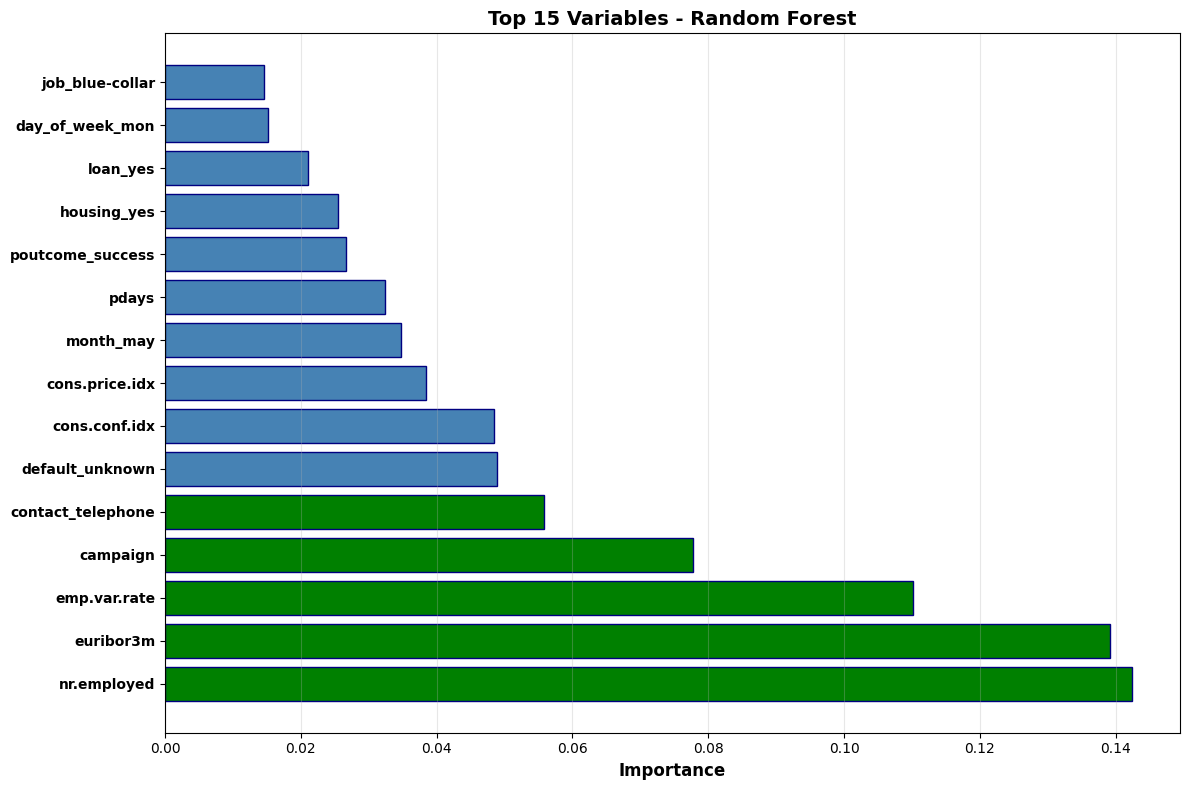


Graphique sauvegarde : 12_feature_importance_rf.png


F1-Score RF : 0.4920 (vs KNN : 0.4242)


In [33]:

# Extraire RF du pipeline
rf_model = best_model_rf.named_steps['rf']

# Features apres encoding
feature_names_encoded = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(categorical_cols).tolist() +
    numerical_cols
)

# Importance
importances_rf = rf_model.feature_importances_
importance_df_rf = pd.DataFrame({
    'Feature': feature_names_encoded,
    'Importance': importances_rf
}).sort_values('Importance', ascending=False)

print("\nTop 15 variables :")
print(importance_df_rf.head(15).to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))
top15_rf = importance_df_rf.head(15)
colors = ['green' if imp > 0.05 else 'steelblue' for imp in top15_rf['Importance']]
ax.barh(range(len(top15_rf)), top15_rf['Importance'], color=colors, edgecolor='navy')
ax.set_yticks(range(len(top15_rf)))
ax.set_yticklabels(top15_rf['Feature'], fontweight='bold')
ax.set_xlabel('Importance', fontweight='bold', fontsize=12)
ax.set_title('Top 15 Variables - Random Forest', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\12_feature_importance_rf.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegarde : 12_feature_importance_rf.png")
print("\n")
print(f"F1-Score RF : {f1_rf:.4f} (vs KNN : {f1_final:.4f})")


## PARTIE 6 : XGBoost (Gradient Boosting)

**Objectif :** Tester l'algorithme état de l'art pour données tabulaires.

**Résultats actuels :**
- KNN : F1 = 0.4242, Recall = 59.72%
- Random Forest : F1 = 0.4920

**Pourquoi XGBoost ?**

1. **État de l'art pour données tabulaires**
   - Gagne la majorité des compétitions Kaggle
   - Performances supérieures à Random Forest généralement
   
2. **Optimisation avancée**
   - Gradient boosting : construit arbres séquentiellement
   - Chaque arbre corrige les erreurs du précédent
   - Régularisation intégrée (évite overfitting)

3. **Gestion native du déséquilibre**
   - `scale_pos_weight` : pondération classe minoritaire
   - Plus efficace que SMOTE dans certains cas

4. **Performances attendues**
   - F1-Score : 0.50-0.55
   - Meilleur équilibre Precision/Recall
   - Moins de faux négatifs

**Hyperparamètres clés :**
- `n_estimators` : Nombre d'arbres (100, 200, 300)
- `max_depth` : Profondeur (3, 5, 7)
- `learning_rate` : Taux d'apprentissage (0.01, 0.1, 0.3)
- `scale_pos_weight` : Ratio no/yes pour déséquilibre

**Avantages vs Random Forest :**
- Boosting > Bagging (séquentiel vs parallèle)
- Meilleure précision généralement
- Régularisation plus fine


In [34]:
# installation de xgboost 
%pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
print("\nXGBoost importe avec succes")

print(f"\nVersion XGBoost : {xgb.__version__}")

# Affichage sécurisé des metrics 
_f1_final = globals().get('f1_final', None)
_f1_rf = globals().get('f1_rf', None)

if _f1_final is not None:
	print(f"  - Baseline KNN : F1 = {_f1_final:.4f}")
else:
	print("  - Baseline KNN : F1 = N/A (exécutez la cellule d'évaluation KNN)")

if _f1_rf is not None:
	print(f"  - Random Forest : F1 = {_f1_rf:.4f}")
else:
	print("  - Random Forest : F1 = N/A (exécutez la cellule d'évaluation Random Forest)")

Note: you may need to restart the kernel to use updated packages.

XGBoost importe avec succes

Version XGBoost : 3.2.0
  - Baseline KNN : F1 = 0.4242
  - Random Forest : F1 = 0.4920


In [35]:
# pipeline 
pipe_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False))
])


In [36]:
# grille de parametres 

# Calculer scale_pos_weight (ratio no/yes)
ratio_no_yes = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nRatio no/yes : {ratio_no_yes:.2f}")

param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__scale_pos_weight': [1, ratio_no_yes]
}

print(f"\nParametres :")
for key, values in param_grid_xgb.items():
    if key == 'xgb__scale_pos_weight':
        print(f"  - {key.replace('xgb__', '')} : [1, {ratio_no_yes:.2f}]")
    else:
        print(f"  - {key.replace('xgb__', '')} : {values}")

nb_comb_xgb = 3 * 3 * 3 * 2  # 54 combinaisons
print(f"\nCombinaisons : {nb_comb_xgb}")
print(f"Avec 5-fold CV : {nb_comb_xgb * 5} = 270 entrainements")




Ratio no/yes : 7.88

Parametres :
  - n_estimators : [100, 200, 300]
  - max_depth : [3, 5, 7]
  - learning_rate : [0.01, 0.1, 0.3]
  - scale_pos_weight : [1, 7.88]

Combinaisons : 54
Avec 5-fold CV : 270 = 270 entrainements


In [37]:
# gridsearchcv
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()

grid_xgb.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nTermine en {elapsed_time/60:.1f} minutes")

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Termine en 5.4 minutes


In [38]:
#resultats 
best_params_xgb = grid_xgb.best_params_
best_score_xgb_cv = grid_xgb.best_score_

print(f"\nMeilleurs hyperparametres :")
for param, value in best_params_xgb.items():
    param_name = param.replace('xgb__', '')
    if param_name == 'scale_pos_weight':
        print(f"  - {param_name} : {value:.2f}")
    else:
        print(f"  - {param_name} : {value}")

print(f"\nMeilleur F1-Score (CV) : {best_score_xgb_cv:.4f}")

# Top 5
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
top5_xgb = results_xgb.nlargest(5, 'mean_test_score')[
    ['param_xgb__n_estimators', 'param_xgb__max_depth', 
     'param_xgb__learning_rate', 'param_xgb__scale_pos_weight',
     'mean_test_score']
]
top5_xgb.columns = ['n_trees', 'max_depth', 'learning_rate', 'scale_weight', 'F1-Score']

print("\nTop 5 :")
print(top5_xgb.to_string(index=False))



Meilleurs hyperparametres :
  - learning_rate : 0.01
  - max_depth : 5
  - n_estimators : 300
  - scale_pos_weight : 1.00

Meilleur F1-Score (CV) : 0.4971

Top 5 :
 n_trees  max_depth  learning_rate  scale_weight  F1-Score
     300          5         0.0100        1.0000    0.4971
     200          5         0.0100        1.0000    0.4961
     100          7         0.0100        1.0000    0.4953
     100          5         0.0100        1.0000    0.4938
     200          7         0.0100        1.0000    0.4936


In [39]:
# evaluation sur le test set 

best_model_xgb = grid_xgb.best_estimator_

y_pred_xgb = best_model_xgb.predict(X_test)
y_prob_xgb = best_model_xgb.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, pos_label=1)
rec_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)
f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)

print(f"\nPerformances XGBoost :")
print(f"  Accuracy  : {acc_xgb:.4f}")
print(f"  Precision : {prec_xgb:.4f}")
print(f"  Recall    : {rec_xgb:.4f}")
print(f"  F1-Score  : {f1_xgb:.4f}")

# ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"  AUC-ROC   : {roc_auc_xgb:.4f}")

# Comparaison
print(f"\n" + "-"*80)
print("COMPARAISON KNN vs RF vs XGB")
print("-"*80)

comparison_3models = pd.DataFrame({
    'Metrique': ['F1-Score', 'Recall', 'Precision', 'AUC-ROC'],
    'KNN': [f1_final, rec_final, prec_final, roc_auc_final],
    'RF': [f1_rf, rec_rf, prec_rf, roc_auc_rf],
    'XGB': [f1_xgb, rec_xgb, prec_xgb, roc_auc_xgb]
})

print("\n")
print(comparison_3models.to_string(index=False))

# Identifier le meilleur
best_f1_idx = comparison_3models[['KNN', 'RF', 'XGB']].loc[0].idxmax()
best_f1_value = comparison_3models[['KNN', 'RF', 'XGB']].loc[0].max()

print(f"\nMeilleur F1-Score : {best_f1_idx} ({best_f1_value:.4f})")

# Matrice confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=[0, 1])
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

print(f"\nMatrice de confusion XGBoost :")
print(cm_xgb)
print(f"\nFaux Negatifs :")
print(f"  KNN : {fn_final:,}")
print(f"  RF  : {fn_rf:,}")
print(f"  XGB : {fn_xgb:,}")


Performances XGBoost :
  Accuracy  : 0.8771
  Precision : 0.4609
  Recall    : 0.5309
  F1-Score  : 0.4934
  AUC-ROC   : 0.7874

--------------------------------------------------------------------------------
COMPARAISON KNN vs RF vs XGB
--------------------------------------------------------------------------------


 Metrique    KNN     RF    XGB
 F1-Score 0.4242 0.4920 0.4934
   Recall 0.5972 0.5700 0.5309
Precision 0.3289 0.4328 0.4609
  AUC-ROC 0.7570 0.7990 0.7874

Meilleur F1-Score : XGB (0.4934)

Matrice de confusion XGBoost :
[[6679  572]
 [ 432  489]]

Faux Negatifs :
  KNN : 371
  RF  : 396
  XGB : 432



Top 15 variables :
          Feature  Importance
      nr.employed      0.2536
     emp.var.rate      0.0772
  default_unknown      0.0700
         loan_yes      0.0651
      housing_yes      0.0577
    cons.conf.idx      0.0519
contact_telephone      0.0414
         campaign      0.0412
   job_technician      0.0343
        month_oct      0.0248
 poutcome_success      0.0232
  day_of_week_thu      0.0177
        euribor3m      0.0170
  day_of_week_wed      0.0165
  job_blue-collar      0.0148


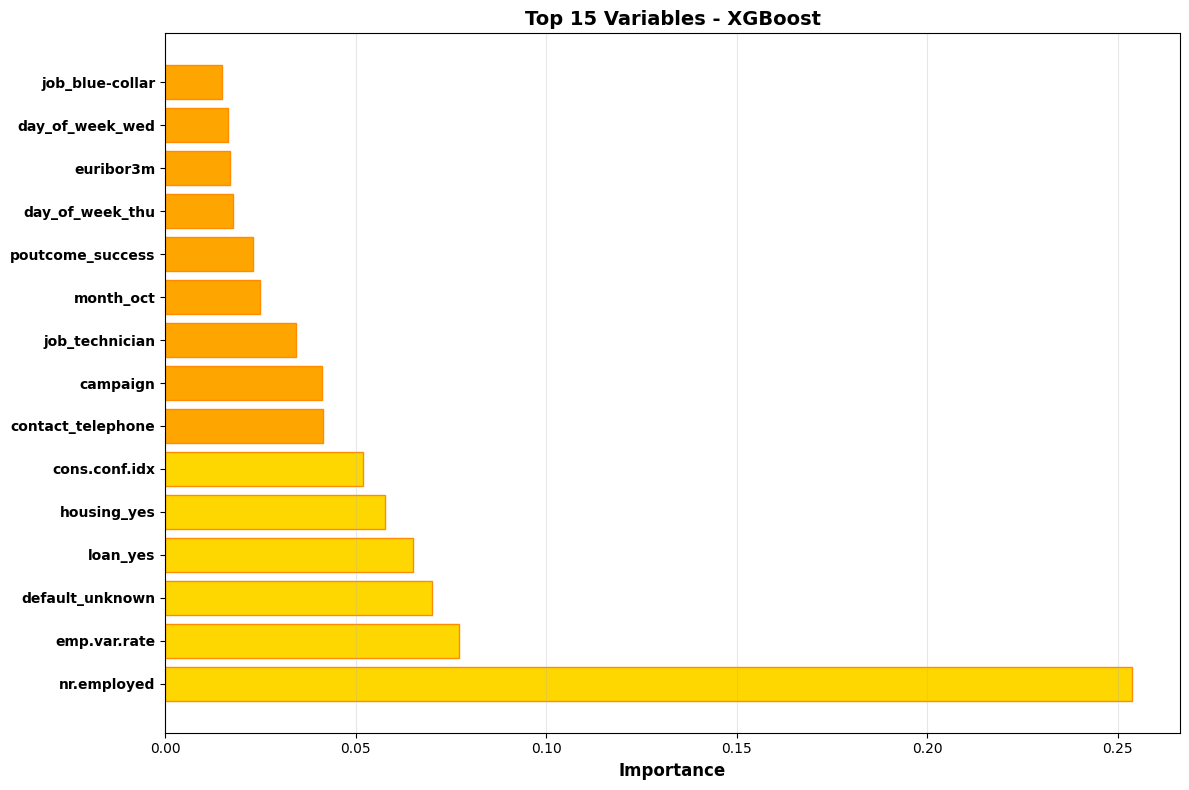


Graphique sauvegarde : 13_feature_importance_xgb.png


F1-Score XGB : 0.4934


In [40]:
# feature importance du xgboost

# Extraiction de   XGB du pipeline
xgb_model = best_model_xgb.named_steps['xgb']

# Importance
importances_xgb = xgb_model.feature_importances_
importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_encoded,
    'Importance': importances_xgb
}).sort_values('Importance', ascending=False)

print("\nTop 15 variables :")
print(importance_df_xgb.head(15).to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))
top15_xgb = importance_df_xgb.head(15)
colors = ['gold' if imp > 0.05 else 'orange' for imp in top15_xgb['Importance']]
ax.barh(range(len(top15_xgb)), top15_xgb['Importance'], color=colors, edgecolor='darkorange')
ax.set_yticks(range(len(top15_xgb)))
ax.set_yticklabels(top15_xgb['Feature'], fontweight='bold')
ax.set_xlabel('Importance', fontweight='bold', fontsize=12)
ax.set_title('Top 15 Variables - XGBoost', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\13_feature_importance_xgb.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegarde : 13_feature_importance_xgb.png")

print("\n" )
print(f"F1-Score XGB : {f1_xgb:.4f}")


## Comparaison finale 

In [43]:
# tableau comparatif des 3 modeles
comparison_final = pd.DataFrame({
    'Modele': ['Baseline (no SMOTE)', 'KNN', 'Random Forest', 'XGBoost'],
    'F1-Score': [f1_baseline, f1_final, f1_rf, f1_xgb],
    'Recall': [rec_baseline, rec_final, rec_rf, rec_xgb],
    'Precision': [prec_baseline, prec_final, prec_rf, prec_xgb],
    'Accuracy': [acc_baseline, acc_final, acc_rf, acc_xgb],
    'AUC-ROC': [roc_auc_baseline, roc_auc_final, roc_auc_rf, roc_auc_xgb],
    'FN (yes rates)': [fn, fn_final, fn_rf, fn_xgb]
})

print("\n")
print(comparison_final.to_string(index=False))



             Modele  F1-Score  Recall  Precision  Accuracy  AUC-ROC  FN (yes rates)
Baseline (no SMOTE)    0.3651  0.2790     0.5277    0.8906   0.7267             664
                KNN    0.4242  0.5972     0.3289    0.8173   0.7570             371
      Random Forest    0.4920  0.5700     0.4328    0.8674   0.7990             396
            XGBoost    0.4934  0.5309     0.4609    0.8771   0.7874             432


In [44]:
# analyse par metrique


# Meilleur F1
best_f1_idx = comparison_final.loc[1:, 'F1-Score'].idxmax()
best_f1_model = comparison_final.loc[best_f1_idx, 'Modele']
best_f1_value = comparison_final.loc[best_f1_idx, 'F1-Score']

# Meilleur Recall
best_recall_idx = comparison_final.loc[1:, 'Recall'].idxmax()
best_recall_model = comparison_final.loc[best_recall_idx, 'Modele']
best_recall_value = comparison_final.loc[best_recall_idx, 'Recall']

# Meilleure Precision
best_prec_idx = comparison_final.loc[1:, 'Precision'].idxmax()
best_prec_model = comparison_final.loc[best_prec_idx, 'Modele']
best_prec_value = comparison_final.loc[best_prec_idx, 'Precision']

# Meilleur AUC
best_auc_idx = comparison_final.loc[1:, 'AUC-ROC'].idxmax()
best_auc_model = comparison_final.loc[best_auc_idx, 'Modele']
best_auc_value = comparison_final.loc[best_auc_idx, 'AUC-ROC']

# Moins de FN
best_fn_idx = comparison_final.loc[1:, 'FN (yes rates)'].idxmin()
best_fn_model = comparison_final.loc[best_fn_idx, 'Modele']
best_fn_value = comparison_final.loc[best_fn_idx, 'FN (yes rates)']

print(f"\nMeilleur F1-Score   : {best_f1_model} ({best_f1_value:.4f})")
print(f"Meilleur Recall     : {best_recall_model} ({best_recall_value:.4f})")
print(f"Meilleure Precision : {best_prec_model} ({best_prec_value:.4f})")
print(f"Meilleur AUC-ROC    : {best_auc_model} ({best_auc_value:.4f})")
print(f"Moins de FN         : {best_fn_model} ({int(best_fn_value)} clients)")


Meilleur F1-Score   : XGBoost (0.4934)
Meilleur Recall     : KNN (0.5972)
Meilleure Precision : XGBoost (0.4609)
Meilleur AUC-ROC    : Random Forest (0.7990)
Moins de FN         : KNN (371 clients)


In [45]:
# selection du model final 

print("\nCriteres de decision :")
print("  1. F1-Score (metrique principale)")
print("  2. Recall (important pour opportunites commerciales)")
print("  3. AUC-ROC (capacite de discrimination)")



Criteres de decision :
  1. F1-Score (metrique principale)
  2. Recall (important pour opportunites commerciales)
  3. AUC-ROC (capacite de discrimination)


In [46]:
# Score combiné : 50% F1 + 30% Recall + 20% AUC normalisé
comparison_final['F1_norm'] = comparison_final['F1-Score'] / comparison_final.loc[1:, 'F1-Score'].max()
comparison_final['Recall_norm'] = comparison_final['Recall'] / comparison_final.loc[1:, 'Recall'].max()
comparison_final['AUC_norm'] = comparison_final['AUC-ROC'] / comparison_final.loc[1:, 'AUC-ROC'].max()

comparison_final['Score_Combine'] = (
    0.5 * comparison_final['F1_norm'] + 
    0.3 * comparison_final['Recall_norm'] + 
    0.2 * comparison_final['AUC_norm']
)

best_combined_idx = comparison_final.loc[1:, 'Score_Combine'].idxmax()
best_model_name = comparison_final.loc[best_combined_idx, 'Modele']

print(f"\n" )
print(f"Meilleur model  : {best_model_name}")


best_row = comparison_final.loc[best_combined_idx]
print(f"\nPerformances du modele retenu :")
print(f"  F1-Score  : {best_row['F1-Score']:.4f}")
print(f"  Recall    : {best_row['Recall']:.4f}")
print(f"  Precision : {best_row['Precision']:.4f}")
print(f"  Accuracy  : {best_row['Accuracy']:.4f}")
print(f"  AUC-ROC   : {best_row['AUC-ROC']:.4f}")
print(f"  FN        : {int(best_row['FN (yes rates)'])} clients yes rates")

# Amélioration vs baseline
print(f"\nAmelioration vs Baseline :")
baseline_f1 = comparison_final.loc[0, 'F1-Score']
improvement = ((best_row['F1-Score'] - baseline_f1) / baseline_f1) * 100
print(f"  F1-Score : +{improvement:.1f}%")
print(f"  De {baseline_f1:.4f} a {best_row['F1-Score']:.4f}")

baseline_fn = comparison_final.loc[0, 'FN (yes rates)']
fn_reduction = baseline_fn - best_row['FN (yes rates)']
fn_reduction_pct = (fn_reduction / baseline_fn) * 100
print(f"  Faux Negatifs : -{fn_reduction_pct:.1f}%")
print(f"  De {int(baseline_fn)} a {int(best_row['FN (yes rates)'])} clients")
print(f"  : {int(fn_reduction)} opportunites commerciales RECUPEREES")




Meilleur model  : Random Forest

Performances du modele retenu :
  F1-Score  : 0.4920
  Recall    : 0.5700
  Precision : 0.4328
  Accuracy  : 0.8674
  AUC-ROC   : 0.7990
  FN        : 396 clients yes rates

Amelioration vs Baseline :
  F1-Score : +34.8%
  De 0.3651 a 0.4920
  Faux Negatifs : -40.4%
  De 664 a 396 clients
  : 268 opportunites commerciales RECUPEREES


In [48]:
# interpretation metier : 

print(f"\nAvec le modele {best_model_name} :")

# Calculer impacts
nb_yes_total = (y_test == 1).sum()
nb_yes_detected = int(best_row['Recall'] * nb_yes_total)
revenu_par_client = 300  # euros (hypothèse)
cout_par_contact = 7  # euros

print(f"\nSur {len(y_test):,} clients testes :")
print(f"  Vrais 'yes' : {nb_yes_total:,}")
print(f"  'Yes' detectes : {nb_yes_detected} ({best_row['Recall']*100:.1f}%)")
print(f"  'Yes' rates : {int(best_row['FN (yes rates)'])}")

# Calcul nombre de prédictions yes
tp_model = nb_yes_detected
fp_model = int(tp_model / best_row['Precision']) - tp_model if best_row['Precision'] > 0 else 0
nb_pred_yes = tp_model + fp_model

cout_total = nb_pred_yes * cout_par_contact
revenu_total = nb_yes_detected * revenu_par_client
benefice = revenu_total - cout_total
roi = (benefice / cout_total * 100) if cout_total > 0 else 0

print(f"\nImpact economique (estimation) :")
print(f"  Predictions 'yes' : {nb_pred_yes:,}")
print(f"  Cout contacts : {cout_total:,} euros")
print(f"  Revenus : {revenu_total:,} euros")
print(f"  Benefice net : {benefice:,} euros")
print(f"  ROI : {roi:.0f}%")


Avec le modele Random Forest :

Sur 8,172 clients testes :
  Vrais 'yes' : 921
  'Yes' detectes : 525 (57.0%)
  'Yes' rates : 396

Impact economique (estimation) :
  Predictions 'yes' : 1,213
  Cout contacts : 8,491 euros
  Revenus : 157,500 euros
  Benefice net : 149,009 euros
  ROI : 1755%


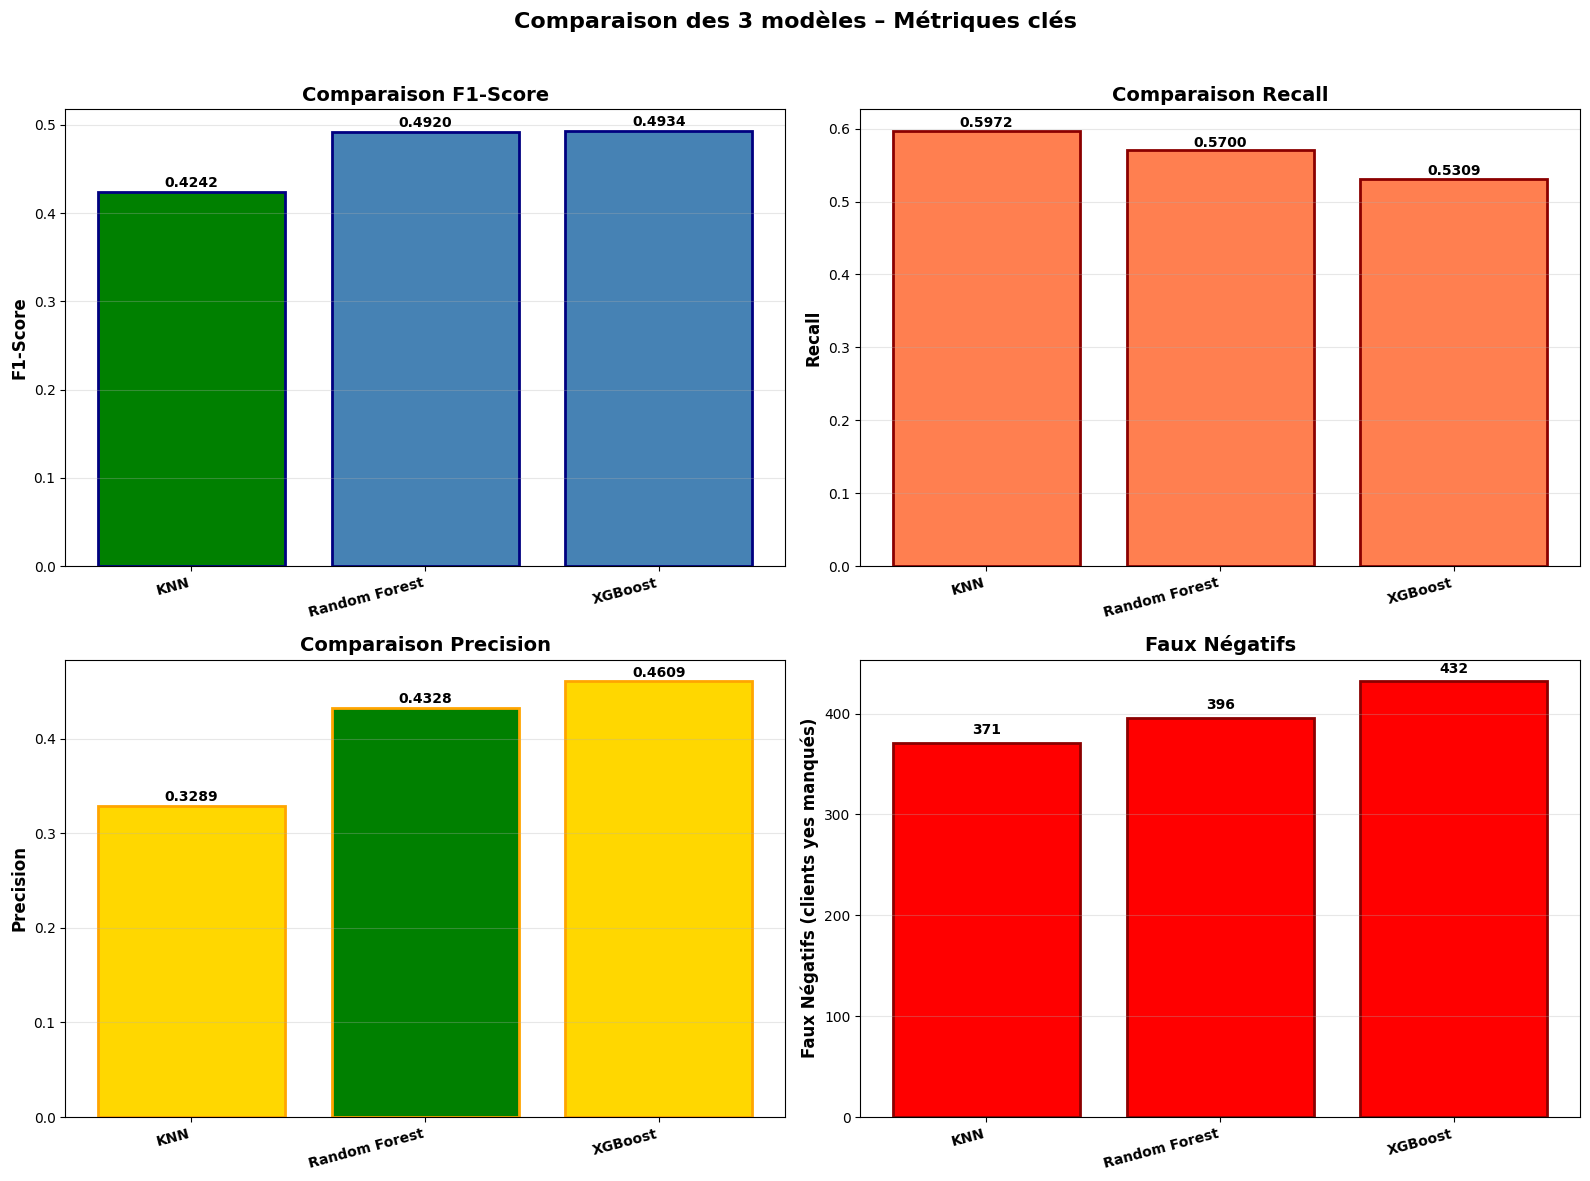


Graphique sauvegardé : 15_comparison_3models_final.png


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  



df_plot = comparison_final.iloc[1:].reset_index(drop=True)  

models_plot = df_plot['Modele'].tolist()
f1_scores   = df_plot['F1-Score'].tolist()
recalls     = df_plot['Recall'].tolist()
precisions  = df_plot['Precision'].tolist()
fns         = df_plot['FN (yes rates)'].tolist()



fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Comparaison des 3 modèles – Métriques clés", fontsize=16, fontweight='bold')



#  F1-Score
colors_f1 = ['green' if i == (best_combined_idx - 1 - 1) else 'steelblue' 
             for i in range(len(f1_scores))]   # -1 pour le slice, -1 car idx commence à 1

axes[0, 0].bar(range(len(models_plot)), f1_scores, color=colors_f1, 
               edgecolor='navy', linewidth=2)
axes[0, 0].set_xticks(range(len(models_plot)))
axes[0, 0].set_xticklabels(models_plot, rotation=15, ha='right', fontweight='bold')
axes[0, 0].set_ylabel('F1-Score', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Comparaison F1-Score', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

for i, v in enumerate(f1_scores):
    axes[0, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', 
                    fontweight='bold', fontsize=10)


#  Recall 
colors_rec = ['green' if (i + 1) == (best_recall_idx - 1) else 'coral' 
              for i in range(len(recalls))]

axes[0, 1].bar(range(len(models_plot)), recalls, color=colors_rec, 
               edgecolor='darkred', linewidth=2)
axes[0, 1].set_xticks(range(len(models_plot)))
axes[0, 1].set_xticklabels(models_plot, rotation=15, ha='right', fontweight='bold')
axes[0, 1].set_ylabel('Recall', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Comparaison Recall', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

for i, v in enumerate(recalls):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', 
                    fontweight='bold', fontsize=10)



#  Precision
colors_prec = ['green' if i == (best_prec_idx - 1 - 1) else 'gold' 
               for i in range(len(precisions))]

axes[1, 0].bar(range(len(models_plot)), precisions, color=colors_prec, 
               edgecolor='orange', linewidth=2)
axes[1, 0].set_xticks(range(len(models_plot)))
axes[1, 0].set_xticklabels(models_plot, rotation=15, ha='right', fontweight='bold')
axes[1, 0].set_ylabel('Precision', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Comparaison Precision', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

for i, v in enumerate(precisions):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', 
                    fontweight='bold', fontsize=10)


#  Faux Négatifs (FN)
colors_fn = ['green' if i == (best_fn_idx - 1 - 1) else 'red' 
             for i in range(len(fns))]

axes[1, 1].bar(range(len(models_plot)), fns, color=colors_fn, 
               edgecolor='darkred', linewidth=2)
axes[1, 1].set_xticks(range(len(models_plot)))
axes[1, 1].set_xticklabels(models_plot, rotation=15, ha='right', fontweight='bold')
axes[1, 1].set_ylabel('Faux Négatifs (clients yes manqués)', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Faux Négatifs', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

for i, v in enumerate(fns):
    axes[1, 1].text(i, v + max(fns)*0.02, f'{int(v)}', ha='center', 
                    fontweight='bold', fontsize=10)

# Ajustement global
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\15_comparison_3models_final.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegardé : 15_comparison_3models_final.png")

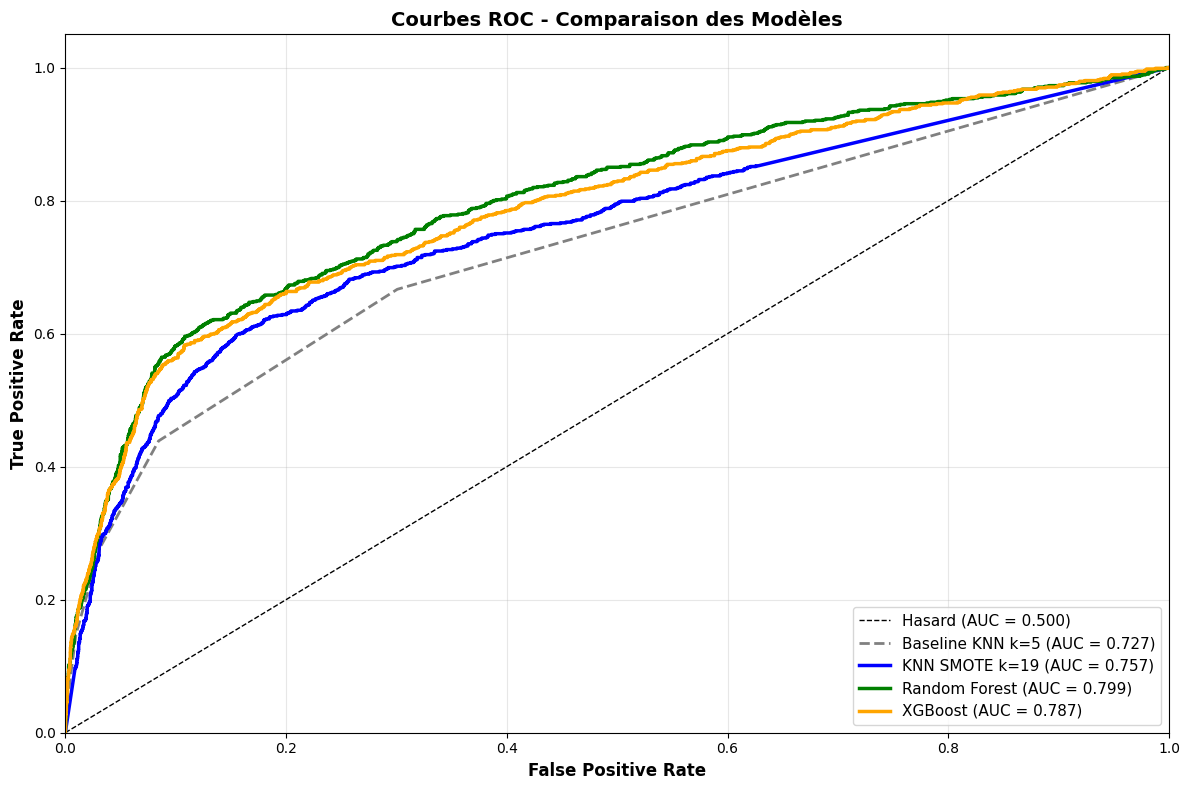


Graphique sauvegardé : 16_roc_comparison_3models.png

MODÈLE FINAL RETENU : Random Forest
F1-Score : 0.4920 (Amélioration +34.8% vs baseline)
Recall   : 0.5700
AUC-ROC  : 0.7990


In [56]:
# Courbe ROC comparée des 3 modèles






fig, ax = plt.subplots(figsize=(12, 8))

# Ligne de hasard (toujours AUC=0.5)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Hasard (AUC = 0.500)')

# Baseline 
ax.plot(fpr_baseline, tpr_baseline, 
        linewidth=2, linestyle='--', color='gray',
        label=f'Baseline KNN k=5 (AUC = {roc_auc_baseline:.3f})')

# Modèle final SMOTE + meilleur k
ax.plot(fpr_final, tpr_final, 
        linewidth=2.5, color='blue',
        label=f'KNN SMOTE k={best_params["knn__n_neighbors"]} (AUC = {roc_auc_final:.3f})')

# Random Forest 
if 'roc_auc_rf' in globals():
    ax.plot(fpr_rf, tpr_rf, 
            linewidth=2.5, color='green',
            label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# XGBoost 
if 'roc_auc_xgb' in globals():
    ax.plot(fpr_xgb, tpr_xgb, 
            linewidth=2.5, color='orange',
            label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')

# Style et labels
ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
ax.set_title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'A:\Mes documents\projet analyse exploiratoire\results\figures\16_roc_comparison_3models.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegardé : 16_roc_comparison_3models.png")




print(f"\nMODÈLE FINAL RETENU : {best_model_name}")
print(f"F1-Score : {best_row['F1-Score']:.4f} (Amélioration +{improvement:.1f}% vs baseline)")
print(f"Recall   : {best_row['Recall']:.4f}")
print(f"AUC-ROC  : {best_row['AUC-ROC']:.4f}")
